Wczytanie danych

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# Sprawdzenie dostępności GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Urządzenie: {device}")

# Transformacje danych
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Rozmiar zgodny z Tiny ImageNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ścieżki do danych
base_dir = '../tiny-imagenet-200'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Wczytanie danych
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

print("Dane zostały pomyślnie wczytane.")


Urządzenie: cuda
Dane zostały pomyślnie wczytane.


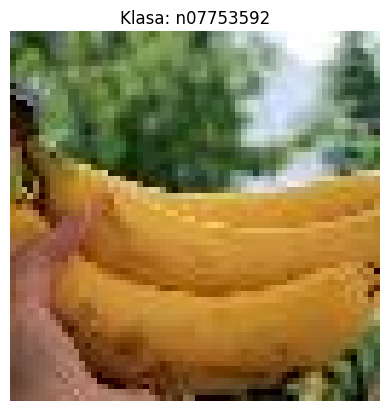

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Funkcja do wyświetlenia losowego obrazu z zestawu danych
def show_random_image(data_loader, class_names):
    # Pobranie losowej partii danych
    images, labels = next(iter(data_loader))
    
    # Wybór losowego indeksu
    idx = np.random.randint(0, len(images))
    image, label = images[idx], labels[idx]
    
    # Odwrócenie normalizacji dla poprawnej wizualizacji
    image = image.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    # Wyświetlenie obrazu
    plt.imshow(image)
    plt.title(f'Klasa: {class_names[label]}')
    plt.axis('off')
    plt.show()

# Lista klas z katalogów (ImageFolder automatycznie tworzy class_to_idx)
class_names = train_dataset.classes

# Wyświetlenie losowego obrazu
show_random_image(train_loader, class_names)


Defincja modeli bazując na wynikach z poprzednich eksperymentów

Model 1: Optymalny (Balanced Model)

10 warstw konwolucyjnych – zgodnie z wcześniejszymi eksperymentami zapewnia najlepszy kompromis między złożonością a stabilnością.

Filtry: 64 → 128 → 128 → 256 – progresywny wzrost liczby filtrów pozwala uchwycić coraz bardziej złożone cechy.

Rozmiar filtrów: 3x3 – mniejsze filtry skutecznie wychwytują lokalne cechy.

Batch Normalization: Zapewnia stabilność treningu i przyspiesza konwergencję.

Dropout (0.4): Zmniejsza ryzyko przeuczenia.

Optymalizator Adam: Dobrze sprawdził się w poprzednich testach przy learning rate = 0.001.

In [2]:
import torch.nn as nn

class BalancedCNN(nn.Module):
    def __init__(self):
        super(BalancedCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 64 filtrów, 3x3
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),  # Pooling po 4 warstwach konwolucyjnych
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)  # Ponownie pooling po kilku warstwach
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512),  # Dopasowane do rozmiaru danych po konwolucjach
            nn.ReLU(),
            nn.Dropout(0.4),  # Regularyzacja
            nn.Linear(512, 200)  # 200 klas w zbiorze Tiny ImageNet
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


Model 2: Słaby (Underfitting Model)
3 warstwy konwolucyjne – eksperymenty wykazały, że zbyt mała liczba warstw ogranicza zdolność modelu do rozpoznawania złożonych cech.

Filtry: 32 → 64 → 128 – mniejsza liczba filtrów ogranicza zdolność modelu do ekstrakcji cech.

Rozmiar filtrów: 5x5 – większe filtry mniej efektywnie wychwytują subtelne wzorce.

Brak Batch Normalization i Dropout – celowo pomijamy te mechanizmy, aby zwiększyć ryzyko niedouczenia.

Optymalizator SGD: Wolniejszy proces uczenia jest celowym zabiegiem w tym przypadku.

In [3]:
class UnderfittingCNN(nn.Module):
    def __init__(self):
        super(UnderfittingCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 200)  # 128 kanałów przy wyjściu i rozmiar 8x8 po poolingach
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


Model 3: Przeuczony (Overfitting Model)
20 warstw konwolucyjnych – eksperymenty pokazały, że bardzo głęboka architektura ma tendencję do przeuczenia.

Filtry: 64 → 128 → 256 → 512 – duża liczba filtrów znacząco zwiększa liczbę parametrów.

Batch Normalization: Pomaga utrzymać stabilność mimo dużej liczby warstw.

Dropout (0.2): Celowo słabsza regularyzacja, aby model mógł łatwiej zapamiętywać dane.

Optymalizator Adam: Używany z learning rate = 0.0001, aby uniknąć niestabilności przy bardzo głębokiej sieci.

In [4]:
import torch
import torch.nn as nn

class OverfittingCNN(nn.Module):
    def __init__(self):
        super(OverfittingCNN, self).__init__()
        
        layers = []
        in_channels = 3
        for i in range(20):
            out_channels = min(64 * (2 ** (i // 5)), 512)
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm2d(out_channels))
            if i % 5 == 4:  # Pooling co 5 warstw
                layers.append(nn.MaxPool2d(2))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)

        # Obliczenie dynamicznego rozmiaru po konwolucjach
        self.flatten_dim = 512 * 4 * 4  # Rozmiar po konwolucjach: (512, 4, 4)

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 1024),  # Poprawione wejście
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 200)  # 200 klas w Tiny ImageNet
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


Eksperyment 1 – Analiza wpływu learning rate

 Hipotezy
BalancedCNN – Jako najlepiej zbalansowany model, powinien działać stabilnie przy umiarkowanych wartościach (0.001 i 0.0001). Przy 0.1 może dojść do niestabilnych skoków funkcji straty.

UnderfittingCNN – Ze względu na prostą architekturę, powinien działać względnie stabilnie nawet przy większych wartościach learning rate, ale może mieć problemy z dokładnością.

OverfittingCNN – Przy zbyt dużym learning rate (0.1) model najprawdopodobniej będzie niestabilny, natomiast przy małych wartościach (0.0001 i 0.00001) może uzyskać bardzo wysoką dokładność kosztem długiego czasu treningu.

In [7]:
import os

# Ustawienia eksperymentu
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]  # Testowane wartości LR
num_epochs = 20
batch_size = 64

# Foldery do zapisu wyników
results_base_folder = '../results/experiment_1'
os.makedirs(results_base_folder, exist_ok=True)

# Tworzenie struktury folderów dla każdego modelu i wartości learning rate
for model_name in ['BalancedCNN', 'UnderfittingCNN', 'OverfittingCNN']:
    for lr in learning_rates:
        folder_path = os.path.join(results_base_folder, f'{model_name}_lr_{lr}')
        os.makedirs(folder_path, exist_ok=True)

print("Struktura folderów została przygotowana.")


Struktura folderów została przygotowana.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Funkcja treningowa
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, model_name, results_folder):
    # Konfiguracja urządzenia
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Kryterium straty i optymalizator
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Listy do przechowywania wyników
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    epoch_times = []

    # Pętla treningowa
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Walidacja
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= val_total
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Czas treningu jednej epoki
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, '
              f'Time: {epoch_time:.2f}s')

        # Zapis modelu po każdej epoce
        torch.save(model.state_dict(), f'{results_folder}/model_epoch_{epoch+1}.pth')

        # Zapis macierzy błędów
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.savefig(f'{results_folder}/confusion_matrix_epoch_{epoch+1}.png')
        plt.close()

        # Zapis raportu klasyfikacji
        report = classification_report(all_labels, all_preds, zero_division=1)
        with open(f'{results_folder}/classification_report_epoch_{epoch+1}.txt', 'w') as f:
            f.write(report)

    # Zapis wyników do CSV
    results = pd.DataFrame({
        'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Train Accuracy': train_accuracies,
        'Validation Loss': val_losses,
        'Validation Accuracy': val_accuracies,
        'Epoch Time': epoch_times
    })
    results.to_csv(f'{results_folder}/training_results.csv', index=False)

    # Wykres przebiegu treningu
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig(f'{results_folder}/training_progress.png')
    plt.show()

    return results


In [ ]:
# Uruchomienie treningu dla BalancedCNN
from copy import deepcopy

# Inicjalizacja modelu
balanced_model = BalancedCNN()

# Pętla po różnych wartościach learning rate
for lr in learning_rates:
    print(f'\n🔵 Trening BalancedCNN z learning rate = {lr}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_1/BalancedCNN_lr_{lr}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(balanced_model)
    
    # Trening modelu
    train_model(model_copy, train_loader, val_loader, num_epochs, lr, 'BalancedCNN', results_folder)


In [ ]:
# Uruchomienie treningu dla UnderfittingCNN
underfitting_model = UnderfittingCNN()

# Pętla po różnych wartościach learning rate
for lr in learning_rates:
    print(f'\n🟠 Trening UnderfittingCNN z learning rate = {lr}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_1/UnderfittingCNN_lr_{lr}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(underfitting_model)
    
    # Trening modelu
    train_model(model_copy, train_loader, val_loader, num_epochs, lr, 'UnderfittingCNN', results_folder)


In [ ]:
# Uruchomienie treningu dla OverfittingCNN
overfitting_model = OverfittingCNN()

# Pętla po różnych wartościach learning rate
for lr in learning_rates:
    print(f'\n🔴 Trening OverfittingCNN z learning rate = {lr}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_1/OverfittingCNN_lr_{lr}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(overfitting_model)
    
    # Trening modelu
    train_model(model_copy, train_loader, val_loader, num_epochs, lr, 'OverfittingCNN', results_folder)


Eksperyment 2 – Analiza wpływu batch size

Hipotezy
BalancedCNN
Małe batch size (np. 8, 32) mogą prowadzić do większej stabilności, ale wolniejszego treningu.
Większe batch size (np. 128, 256) mogą przyspieszyć trening, ale ryzyko przeuczenia wzrośnie.

UnderfittingCNN
Większe batch size (np. 128, 256) mogą poprawić stabilność gradientów w prostym modelu, ale mogą nie zwiększyć znacząco dokładności.
Małe batch size mogą prowadzić do niestabilnej konwergencji.

OverfittingCNN
Większe batch size mogą spowodować niestabilne gradienty w tym bardzo złożonym modelu.
Małe batch size mogą być kluczowe, by uniknąć problemu z eksplodującymi gradientami.


In [16]:
import os

# Ustawienia eksperymentu
batch_sizes = [8, 32, 64, 128, 256]  # Testowane wartości batch size
num_epochs = 20
learning_rate = 0.001  # Stała wartość, aby wykluczyć wpływ innych zmiennych

# Foldery do zapisu wyników
results_base_folder = '../results/experiment_2'
os.makedirs(results_base_folder, exist_ok=True)

# Tworzenie struktury folderów dla każdego modelu i wartości batch size
for model_name in ['BalancedCNN', 'UnderfittingCNN', 'OverfittingCNN']:
    for bs in batch_sizes:
        folder_path = os.path.join(results_base_folder, f'{model_name}_bs_{bs}')
        os.makedirs(folder_path, exist_ok=True)

print("Struktura folderów została przygotowana.")


Struktura folderów została przygotowana.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Funkcja treningowa z dynamicznym batch size
def train_model(model, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, model_name, results_folder):
    # Konfiguracja urządzenia
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Dostosowanie DataLoader'ów z dynamicznym batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Kryterium straty i optymalizator
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Listy do przechowywania wyników
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    epoch_times = []

    # Pętla treningowa
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Walidacja
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= val_total
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Czas treningu jednej epoki
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, '
              f'Time: {epoch_time:.2f}s')

        # Zapis modelu po każdej epoce
        torch.save(model.state_dict(), f'{results_folder}/model_epoch_{epoch+1}.pth')

        # Zapis macierzy błędów
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.savefig(f'{results_folder}/confusion_matrix_epoch_{epoch+1}.png')
        plt.close()

        # Zapis raportu klasyfikacji
        report = classification_report(all_labels, all_preds, zero_division=1)
        with open(f'{results_folder}/classification_report_epoch_{epoch+1}.txt', 'w') as f:
            f.write(report)

    # Zapis wyników do CSV
    results = pd.DataFrame({
        'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Train Accuracy': train_accuracies,
        'Validation Loss': val_losses,
        'Validation Accuracy': val_accuracies,
        'Epoch Time': epoch_times
    })
    results.to_csv(f'{results_folder}/training_results.csv', index=False)

    # Wykres przebiegu treningu
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig(f'{results_folder}/training_progress.png')
    plt.show()

    return results


In [ ]:
from copy import deepcopy

# Inicjalizacja modelu
balanced_model = BalancedCNN()

# Pętla po różnych wartościach batch size
for bs in batch_sizes:
    print(f'\n🔵 Trening BalancedCNN z batch size = {bs}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_2/BalancedCNN_bs_{bs}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(balanced_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, bs, 'BalancedCNN', results_folder)


In [ ]:
# Uruchomienie treningu dla UnderfittingCNN
underfitting_model = UnderfittingCNN()

# Pętla po różnych wartościach batch size
for bs in batch_sizes:
    print(f'\n🟠 Trening UnderfittingCNN z batch size = {bs}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_2/UnderfittingCNN_bs_{bs}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(underfitting_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, bs, 'UnderfittingCNN', results_folder)


In [ ]:
# Uruchomienie treningu dla OverfittingCNN
overfitting_model = OverfittingCNN()

# Pętla po różnych wartościach batch size
for bs in batch_sizes:
    print(f'\n🔴 Trening OverfittingCNN z batch size = {bs}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_2/OverfittingCNN_bs_{bs}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(overfitting_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, bs, 'OverfittingCNN', results_folder)


Eksperyment 3 – Porównanie optymalizatorów

BalancedCNN
Adam lub RMSprop powinny zapewnić najlepszą równowagę między stabilnością a szybkością uczenia.
SGD może działać poprawnie, ale wymaga optymalnego learning rate.

UnderfittingCNN
SGD lub Adagrad mogą być dobrym wyborem ze względu na prostą architekturę modelu.
Adam może nieznacznie przyspieszyć trening, ale niekoniecznie poprawi końcowe wyniki.

OverfittingCNN
AdamW lub RMSprop mogą okazać się kluczowe, aby utrzymać stabilność gradientów w tym bardzo głębokim modelu.
SGD może działać niestabilnie bez dodatkowych mechanizmów, takich jak momentum.


In [6]:
import os

# Ustawienia eksperymentu
optimizers_to_test = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'AdamW']  # Testowane optymalizatory
num_epochs = 20
batch_size = 64  # Stała wartość batch size, aby uniknąć wpływu innych zmiennych
learning_rate = 0.001  # Stała wartość learning rate

# Foldery do zapisu wyników
results_base_folder = '../results/experiment_3'
os.makedirs(results_base_folder, exist_ok=True)

# Tworzenie struktury folderów dla każdego modelu i optymalizatora
for model_name in ['BalancedCNN', 'UnderfittingCNN', 'OverfittingCNN']:
    for optimizer_name in optimizers_to_test:
        folder_path = os.path.join(results_base_folder, f'{model_name}_{optimizer_name}')
        os.makedirs(folder_path, exist_ok=True)

print("Struktura folderów została przygotowana.")


Struktura folderów została przygotowana.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Funkcja treningowa z dynamicznym wyborem optymalizatora
def train_model(model, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, optimizer_name, model_name, results_folder):
    # Konfiguracja urządzenia
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Dostosowanie DataLoader'ów
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Kryterium straty
    criterion = nn.CrossEntropyLoss()

    # Wybór optymalizatora na podstawie argumentu
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Nieznany optymalizator: {optimizer_name}")

    # Listy do przechowywania wyników
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    epoch_times = []

    # Pętla treningowa
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Walidacja
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= val_total
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Czas treningu jednej epoki
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        print(f'{model_name} - {optimizer_name} - Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, '
              f'Time: {epoch_time:.2f}s')

        # Zapis modelu po każdej epoce
        torch.save(model.state_dict(), f'{results_folder}/model_epoch_{epoch+1}.pth')

        # Zapis macierzy błędów
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.savefig(f'{results_folder}/confusion_matrix_epoch_{epoch+1}.png')
        plt.close()

        # Zapis raportu klasyfikacji
        report = classification_report(all_labels, all_preds, zero_division=1)
        with open(f'{results_folder}/classification_report_epoch_{epoch+1}.txt', 'w') as f:
            f.write(report)

    # Zapis wyników do CSV
    results = pd.DataFrame({
        'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Train Accuracy': train_accuracies,
        'Validation Loss': val_losses,
        'Validation Accuracy': val_accuracies,
        'Epoch Time': epoch_times
    })
    results.to_csv(f'{results_folder}/training_results.csv', index=False)

    # Wykres przebiegu treningu
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig(f'{results_folder}/training_progress.png')
    plt.show()

    return results


In [ ]:
from copy import deepcopy

# Inicjalizacja modelu
balanced_model = BalancedCNN()

# Pętla po różnych optymalizatorach
for optimizer_name in optimizers_to_test:
    print(f'\n🔵 Trening BalancedCNN z optymalizatorem = {optimizer_name}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_3/BalancedCNN_{optimizer_name}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(balanced_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, optimizer_name, 'BalancedCNN', results_folder)


In [ ]:
# Uruchomienie treningu dla UnderfittingCNN
underfitting_model = UnderfittingCNN()

# Pętla po różnych optymalizatorach
for optimizer_name in optimizers_to_test:
    print(f'\n🟠 Trening UnderfittingCNN z optymalizatorem = {optimizer_name}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_3/UnderfittingCNN_{optimizer_name}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(underfitting_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, optimizer_name, 'UnderfittingCNN', results_folder)


In [ ]:
# Uruchomienie treningu dla OverfittingCNN
overfitting_model = OverfittingCNN()

# Pętla po różnych optymalizatorach
for optimizer_name in optimizers_to_test:
    print(f'\n🔴 Trening OverfittingCNN z optymalizatorem = {optimizer_name}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_3/OverfittingCNN_{optimizer_name}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(overfitting_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, optimizer_name, 'OverfittingCNN', results_folder)


Eksperyment 4 – Badanie różnych metod regularyzacji

Hipotezy
BalancedCNN
Dropout i Batch Normalization powinny zapewnić dobrą równowagę między stabilnością a skutecznością.
L2 Regularization może dodatkowo poprawić generalizację.

UnderfittingCNN
Batch Normalization powinno poprawić stabilność, natomiast Dropout może spowolnić konwergencję.
Early Stopping może być skuteczne przy prostym modelu, gdyż ograniczy niepotrzebne epoki.

OverfittingCNN
Dropout oraz L2 Regularization będą kluczowe w redukcji przeuczenia.
Batch Normalization oraz Layer Normalization mogą poprawić stabilność gradientów przy bardzo głębokiej architekturze.

In [11]:
import os

# Ustawienia eksperymentu
regularization_methods = ['Dropout', 'BatchNorm', 'L2_Regularization', 'EarlyStopping', 'LayerNorm']
num_epochs = 20
batch_size = 64
learning_rate = 0.001  # Stała wartość learning rate

# Foldery do zapisu wyników
results_base_folder = '../results/experiment_4'
os.makedirs(results_base_folder, exist_ok=True)

# Tworzenie struktury folderów dla każdego modelu i metody regularyzacji
for model_name in ['BalancedCNN', 'UnderfittingCNN', 'OverfittingCNN']:
    for reg_method in regularization_methods:
        folder_path = os.path.join(results_base_folder, f'{model_name}_{reg_method}')
        os.makedirs(folder_path, exist_ok=True)

print("Struktura folderów została przygotowana.")


Struktura folderów została przygotowana.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Funkcja treningowa z dynamicznym wyborem metody regularyzacji
def train_model(model, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, reg_method, model_name, results_folder):
    # Konfiguracja urządzenia
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Dostosowanie DataLoader'ów
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Kryterium straty
    criterion = nn.CrossEntropyLoss()

    # Optymalizator (Adam dla spójności z wcześniejszymi eksperymentami)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Dodanie regularyzacji do modelu na podstawie wyboru
    if reg_method == 'Dropout':
        model.fc_layers.add_module("Dropout", nn.Dropout(0.4))
    elif reg_method == 'BatchNorm':
        for layer in model.conv_layers:
            if isinstance(layer, nn.Conv2d):
                model.conv_layers.add_module(f"BatchNorm_{layer.out_channels}", nn.BatchNorm2d(layer.out_channels))
    elif reg_method == 'L2_Regularization':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    elif reg_method == 'EarlyStopping':
        early_stopping = True
        best_loss = float('inf')
        patience = 3  # Wczesne zatrzymanie po 3 epokach bez poprawy
        patience_counter = 0
    elif reg_method == 'LayerNorm':
        for layer in model.fc_layers:
            if isinstance(layer, nn.Linear):
                model.fc_layers.add_module(f"LayerNorm_{layer.out_features}", nn.LayerNorm(layer.out_features))
    else:
        raise ValueError(f"Nieznana metoda regularyzacji: {reg_method}")

    # Listy do przechowywania wyników
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    epoch_times = []

    # Pętla treningowa
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Walidacja
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= val_total
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Wczesne zatrzymanie (Early Stopping)
        if reg_method == 'EarlyStopping':
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Wczesne zatrzymanie treningu po {epoch + 1} epokach.')
                    break

        # Czas treningu jednej epoki
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        print(f'{model_name} - {reg_method} - Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, '
              f'Time: {epoch_time:.2f}s')

        # Zapis modelu po każdej epoce
        torch.save(model.state_dict(), f'{results_folder}/model_epoch_{epoch+1}.pth')

        # Zapis macierzy błędów
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.savefig(f'{results_folder}/confusion_matrix_epoch_{epoch+1}.png')
        plt.close()

        # Zapis raportu klasyfikacji
        report = classification_report(all_labels, all_preds, zero_division=1)
        with open(f'{results_folder}/classification_report_epoch_{epoch+1}.txt', 'w') as f:
            f.write(report)

    # Zapis wyników do CSV
    results = pd.DataFrame({
        'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Train Accuracy': train_accuracies,
        'Validation Loss': val_losses,
        'Validation Accuracy': val_accuracies,
        'Epoch Time': epoch_times
    })
    results.to_csv(f'{results_folder}/training_results.csv', index=False)

    # Wykres przebiegu treningu
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'{model_name} - {reg_method} - Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig(f'{results_folder}/training_progress.png')
    plt.show()

    return results


In [ ]:
from copy import deepcopy

# Inicjalizacja modelu
balanced_model = BalancedCNN()

# Pętla po różnych metodach regularyzacji
for reg_method in regularization_methods:
    print(f'\n🔵 Trening BalancedCNN z regularyzacją = {reg_method}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_4/BalancedCNN_{reg_method}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(balanced_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, reg_method, 'BalancedCNN', results_folder)


In [ ]:
# Uruchomienie treningu dla UnderfittingCNN
underfitting_model = UnderfittingCNN()

# Pętla po różnych metodach regularyzacji
for reg_method in regularization_methods:
    print(f'\n🟠 Trening UnderfittingCNN z regularyzacją = {reg_method}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_4/UnderfittingCNN_{reg_method}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(underfitting_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, reg_method, 'UnderfittingCNN', results_folder)


In [ ]:
# Uruchomienie treningu dla OverfittingCNN
overfitting_model = OverfittingCNN()

# Pętla po różnych metodach regularyzacji
for reg_method in regularization_methods:
    print(f'\n🔴 Trening OverfittingCNN z regularyzacją = {reg_method}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_4/OverfittingCNN_{reg_method}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(overfitting_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, reg_method, 'OverfittingCNN', results_folder)


Eksperyment 5 – Analiza wpływu augmentacji danych

BalancedCNN
Random Crop i Random Flip powinny poprawić zdolność modelu do rozpoznawania danych wejściowych w różnych pozycjach.

UnderfittingCNN
Color Jitter i Gaussian Noise mogą poprawić odporność prostego modelu na zniekształcenia danych.

OverfittingCNN
Random Rotation oraz Random Crop mogą znacząco poprawić generalizację modelu, który ma tendencję do przeuczenia.

In [16]:
import os

# Ustawienia eksperymentu
augmentation_methods = ['RandomCrop', 'RandomFlip', 'ColorJitter', 'GaussianNoise', 'RandomRotation']
num_epochs = 20
batch_size = 64
learning_rate = 0.001  # Stała wartość learning rate

# Foldery do zapisu wyników
results_base_folder = '../results/experiment_5'
os.makedirs(results_base_folder, exist_ok=True)

# Tworzenie struktury folderów dla każdego modelu i techniki augmentacji
for model_name in ['BalancedCNN', 'UnderfittingCNN', 'OverfittingCNN']:
    for aug_method in augmentation_methods:
        folder_path = os.path.join(results_base_folder, f'{model_name}_{aug_method}')
        os.makedirs(folder_path, exist_ok=True)

print("Struktura folderów została przygotowana.")


Struktura folderów została przygotowana.


In [17]:
import torchvision.transforms as transforms

# Funkcja augmentacji danych na podstawie wybranej metody
def get_augmentation(aug_method):
    if aug_method == 'RandomCrop':
        return transforms.RandomCrop((56, 56))  # Przycięcie obrazu do 56x56 z losową lokalizacją
    elif aug_method == 'RandomFlip':
        return transforms.RandomHorizontalFlip(p=0.5)  # Losowe odbicie poziome
    elif aug_method == 'ColorJitter':
        return transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)  
    elif aug_method == 'GaussianNoise':
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.05),  # Szum gaussowski
            transforms.ToPILImage()
        ])
    elif aug_method == 'RandomRotation':
        return transforms.RandomRotation(30)  # Losowy obrót o ±30°
    else:
        raise ValueError(f"Nieznana metoda augmentacji: {aug_method}")

# Funkcja treningowa z dynamicznym wyborem augmentacji
def train_model(model, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, aug_method, model_name, results_folder):
    # Konfiguracja urządzenia
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Dostosowanie augmentacji do danych treningowych
    train_transform = transforms.Compose([
        get_augmentation(aug_method),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Walidacja pozostaje bez augmentacji
    val_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Stworzenie nowych zestawów danych z odpowiednimi transformacjami
    train_dataset.transform = train_transform
    val_dataset.transform = val_transform

    # Dostosowanie DataLoader'ów
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Kryterium straty i optymalizator
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Listy do przechowywania wyników
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    epoch_times = []

    # Pętla treningowa
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Walidacja
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= val_total
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Czas treningu jednej epoki
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        print(f'{model_name} - {aug_method} - Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, '
              f'Time: {epoch_time:.2f}s')

        # Zapis modelu po każdej epoce
        torch.save(model.state_dict(), f'{results_folder}/model_epoch_{epoch+1}.pth')

    # Zapis wyników do CSV
    results = pd.DataFrame({
        'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Train Accuracy': train_accuracies,
        'Validation Loss': val_losses,
        'Validation Accuracy': val_accuracies,
        'Epoch Time': epoch_times
    })
    results.to_csv(f'{results_folder}/training_results.csv', index=False)

    # Wykres przebiegu treningu
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'{model_name} - {aug_method} - Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig(f'{results_folder}/training_progress.png')
    plt.show()

    return results


In [ ]:
from copy import deepcopy

# Inicjalizacja modelu
balanced_model = BalancedCNN()

# Pętla po różnych technikach augmentacji
for aug_method in augmentation_methods:
    print(f'\n🔵 Trening BalancedCNN z augmentacją = {aug_method}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_5/BalancedCNN_{aug_method}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(balanced_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, aug_method, 'BalancedCNN', results_folder)


In [ ]:
# Uruchomienie treningu dla UnderfittingCNN
underfitting_model = UnderfittingCNN()

# Pętla po różnych technikach augmentacji
for aug_method in augmentation_methods:
    print(f'\n🟠 Trening UnderfittingCNN z augmentacją = {aug_method}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_5/UnderfittingCNN_{aug_method}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(underfitting_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, aug_method, 'UnderfittingCNN', results_folder)


In [ ]:
# Uruchomienie treningu dla OverfittingCNN
overfitting_model = OverfittingCNN()

# Pętla po różnych technikach augmentacji
for aug_method in augmentation_methods:
    print(f'\n🔴 Trening OverfittingCNN z augmentacją = {aug_method}')
    
    # Ścieżka zapisu wyników
    results_folder = f'../results/experiment_5/OverfittingCNN_{aug_method}'
    
    # Kopia modelu dla uniknięcia nadpisania wag
    model_copy = deepcopy(overfitting_model)
    
    # Trening modelu
    train_model(model_copy, train_dataset, val_dataset, num_epochs, learning_rate, batch_size, aug_method, 'OverfittingCNN', results_folder)
